In [1]:

import sys
sys.path.append('/home/jlbernal/preLIMinary')
#sys.path.append('/home-2/gsatopo1@jhu.edu/library/my_lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
import copy
import pmesh
from astropy.io import fits
import dask.array as da
import astropy.constants as cu
from warnings import warn

import pickle

#kitsune   = '#D9972F'
#seiheki   = '#478384'
#shuan     = '#740A00'
#aonibi      = '#324356'
#shion       = '#968ABD'
#suoko     = '#B23E52'
#shironeri    = '#FCFAF2'


#colors = [suoko,seiheki,kitsune,'#79a43a',aonibi,shion,'#828282']
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
#plt.rcParams['lines.linewidth'] = 3.0
#plt.rcParams['axes.linewidth'] = 2.

#palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']

from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/jlbernal/LightCone_S82_UM'

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

### Colors and maps

In [2]:
koiai       = '#002E4E'
aiiro     = '#105779'
kujyaku   = '#008E74'
shuan     = '#740A00'
suo       = '#7E2639'
kitsune   = '#D9972F'
tamago    = '#FFDF85'
ominaeshi   = '#F2F2B0'
chojizome = '#DDB87E'
azuki     = '#A04940'
kitsune   = '#D9972F'
seiheki   = '#478384'
aonibi      = '#324356'
shion       = '#968ABD'



#map_blue = tri_map(koiai,aiiro,kujyaku)
#map_red = tri_map(shuan,suo,kitsune)

def tri_map(col1,col2,col3):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2,col3])
    return cmap

def five_map(col1,col2,col3,col4,col5):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2,col3,col4,col5])
    return cmap

map_blue = tri_map(koiai,kujyaku,ominaeshi)
map_red = tri_map(shuan,azuki,chojizome)#tamago)
map_br = five_map(koiai,seiheki,ominaeshi,kitsune,shuan)
map_br_3 = tri_map(koiai,ominaeshi,shuan)

def disptri(col1,col2,col3):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = tri_map(col1,col2,col3)
    plt.imshow(arr,cmap=cmap)
    
def disp5(col1,col2,col3,col4,col5):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = five_map(col1,col2,col3,col4,col5)
    plt.imshow(arr,cmap=cmap)
    
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

def dispmap(cols):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = makemap(cols)
    plt.imshow(arr,cmap=cmap)
    
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
gabimap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

### Tools

In [3]:
def save_pickle(name,obj):
    '''
    name without extension
    '''
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_pickle(name):
    '''
    name without extensions
    '''
    with open(name+'.pickle', 'rb') as handle:
        obj = pickle.load(handle)
    return obj

def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)


### Amazing Name calls

In [4]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=0.5*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=3,
                      spectral_supersample=3,
                      cube_mode='inner_cube',
                      Nmu=20,
                      kmax=3*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, do_angular_smooth=True,
                   do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.81568736,'beta':3.43531917,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params


# example plot

In [5]:
LC_CO=make_measurements(LC_params('CO'))


In [6]:
LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(beam_FWHM=4*u.arcmin,dnu=31.25*u.MHz,angular_supersample=20,spectral_supersample=10,do_spectral_smooth=True,do_angular_smooth=True,do_downsample=False)
CO_map = LC_CO.obs_3d_map
LC_CII=make_measurements(LC_params('CII'))
LC_CII.update(beam_FWHM=35*u.arcsec,dnu=5.5*u.GHz,angular_supersample=14,spectral_supersample=10,do_spectral_smooth=True,do_angular_smooth=True,do_downsample=False)
CII_map = LC_CII.obs_3d_map


/home/jlbernal/preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.1409068782773425
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_161.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_162.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_163.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_164.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_165.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_169.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_171.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_173.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fi

/home/jlbernal/preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.14610088383221842
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))
/home/jlbernal/preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.14090687827734283
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_161.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_162.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_163.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_164.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_165.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_169.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_171.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_173.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fi

/home/jlbernal/preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.14610088383221842
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [7]:
rr = np.linspace(LC_CO.cosmo.comoving_radial_distance(2.5),LC_CO.cosmo.comoving_radial_distance(3.5),10)
zz = LC_CO.cosmo.redshift_at_comoving_radial_distance(rr)
nu_CO=115.271*u.GHz
nu_obs_CO = nu_CO.value/(1+zz)
nu_CII=1900.539*u.GHz
nu_obs_CII = nu_CII.value/(1+zz)


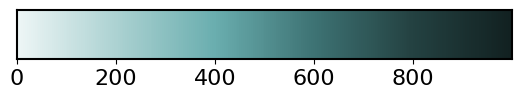

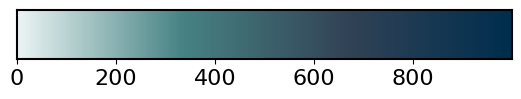

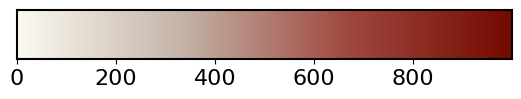

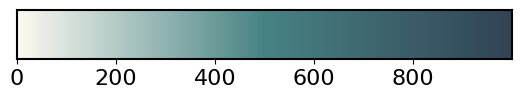

In [8]:
ominaeshi   = '#F2F2B0'
dark_blue='#324356'
seihakuji = '#EBF4F4'
light_red='#c4b3a7'
suoko     = '#B23E52'
shironeri    = '#FCFAF2'


dispmap(['#eef6f6','#acd2d2','#6aaeaf','#3e7374','#244242','#122121'])
dispmap([seihakuji,seiheki,dark_blue,koiai])
dispmap([shironeri,light_red,azuki,shuan])
dispmap([shironeri,seiheki,dark_blue])

blues = makemap([shironeri,seiheki,dark_blue])
reds = makemap([shironeri,light_red,azuki,shuan])

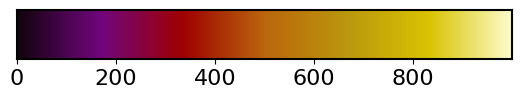

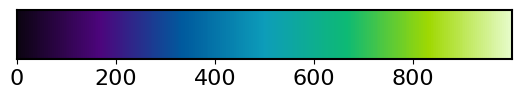

In [9]:
dispmap(['#12040e','#71067d','#9e0000','#ba660d','#ba970d','#d9c302','#fcfcca'])

dispmap(['#0c0412','#4d067d','#005a9e','#0d9dba','#0dba75','#a0d902','#e7fcca'])

In [10]:
warm = makemap(['#12040e','#71067d','#9e0000','#ba660d','#ba970d','#d9c302','#fcfcca'])
cold = makemap(['#0c0412','#4d067d','#005a9e','#0d9dba','#0dba75','#a0d902','#e7fcca'])

<ipython-input-11-40ac66c97d6b>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


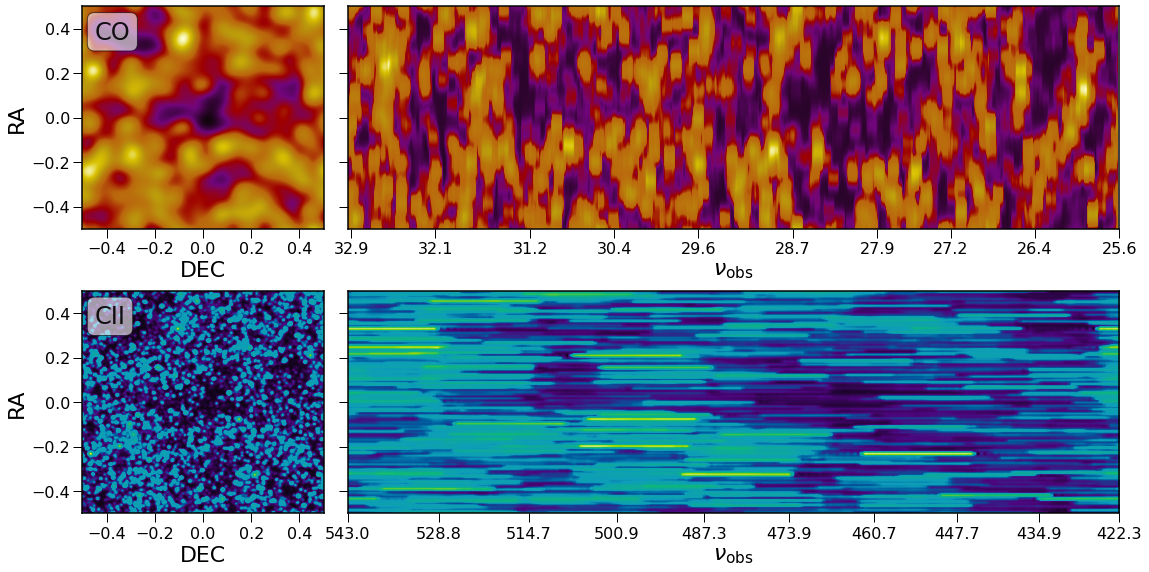

In [11]:

gs_plot = gridspec.GridSpec(2, 4,left=0.07,bottom=0.1,right=0.97,top=0.98,wspace=.1,hspace=.28)
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(gs_plot[0,0])
map_to_plot = CO_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(-0.5,0.5,-0.5,0.5),cmap=warm,norm=norm,aspect='auto')
ax.set_ylabel('RA',fontsize=22)
ax.set_xlabel('DEC',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_xticks([-0.4,-0.2,0.,0.2,0.4])
ax.text(0.05,0.94,'CO',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[0,1:])
map_to_plot = CO_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(nu_obs_CO[0],nu_obs_CO[-1],-0.5,0.5), cmap=warm,norm=norm,aspect='auto')
ax.set_xlabel(r'$\nu_{\rm obs}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CO,1))

ax = plt.subplot(gs_plot[1,0])
map_to_plot = CII_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(-0.5,0.5,-0.5,0.5), cmap=cold,norm=norm,aspect='auto')
ax.set_ylabel('CII', fontsize=26)
ax.set_ylabel('RA',fontsize=22)
ax.set_xlabel('DEC',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_xticks([-0.4,-0.2,0.,0.2,0.4])
ax.text(0.05,0.94,r'CII',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[1,1:])
map_to_plot = CII_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=0,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
ax.imshow(map_to_plot, extent=(nu_obs_CII[0],nu_obs_CII[-1],-0.5,0.5), cmap=cold,norm=norm,aspect='auto')
ax.set_xlabel(r'$\nu_{\rm obs}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CII,1))

plt.tight_layout()
#plt.savefig('../../LIM_maps.png', dpi=200)
plt.show()

<ipython-input-12-3b5bba628935>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


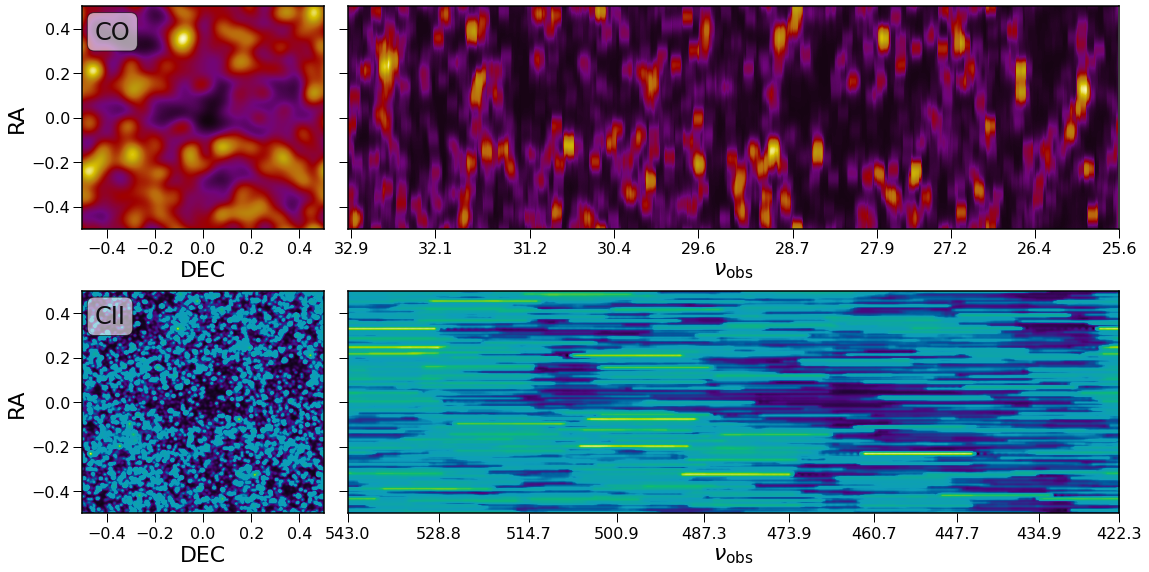

In [12]:

gs_plot = gridspec.GridSpec(2, 4,left=0.07,bottom=0.1,right=0.97,top=0.98,wspace=.1,hspace=.28)
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(gs_plot[0,0])
map_to_plot = CO_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=np.max(map_to_plot)/3,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
pos = ax.imshow(map_to_plot, extent=(-0.5,0.5,-0.5,0.5),cmap=warm,aspect='auto',norm=norm)
ax.set_ylabel('RA',fontsize=22)
ax.set_xlabel('DEC',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_xticks([-0.4,-0.2,0.,0.2,0.4])
ax.text(0.05,0.94,'CO',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[0,1:])
map_to_plot = CO_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=np.max(map_to_plot)/3,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
pos = ax.imshow(map_to_plot, extent=(nu_obs_CO[0],nu_obs_CO[-1],-0.5,0.5), cmap=warm,aspect='auto',norm=norm)
ax.set_xlabel(r'$\nu_{\rm obs}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CO,1))

ax = plt.subplot(gs_plot[1,0])
map_to_plot = CII_map.preview(axes=[1,2])
norm = clrs.TwoSlopeNorm(vcenter=np.min(map_to_plot)/4,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
pos = ax.imshow(map_to_plot, extent=(-0.5,0.5,-0.5,0.5), cmap=cold,aspect='auto',norm=norm)
ax.set_ylabel('CII', fontsize=26)
ax.set_ylabel('RA',fontsize=22)
ax.set_xlabel('DEC',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_xticks([-0.4,-0.2,0.,0.2,0.4])
ax.text(0.05,0.94,r'CII',fontsize=24,va='top',ha='left',
      bbox=dict(boxstyle="round",fc='w',ec='k',alpha=0.6),color='k',
      multialignment='center',alpha=0.9,transform=ax.transAxes)

ax = plt.subplot(gs_plot[1,1:])
map_to_plot = CII_map.preview(axes=[1,0])
norm = clrs.TwoSlopeNorm(vcenter=np.min(map_to_plot)/4,vmax=np.max(map_to_plot),vmin=np.min(map_to_plot))
pos = ax.imshow(map_to_plot, extent=(nu_obs_CII[0],nu_obs_CII[-1],-0.5,0.5), cmap=cold,aspect='auto',norm=norm)
ax.set_xlabel(r'$\nu_{\rm obs}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.tick_params(axis='y',width=1,length=9,labelsize=0)
ax.set_yticks([-0.4,-0.2,0.,0.2,0.4])
ax.set_yticklabels(['','','','',''])
ax.set_xticks(np.round(nu_obs_CII,1))

plt.tight_layout()
#plt.savefig('../../LIM_maps.png', dpi=200)
plt.show()

# Interloper plot

In [5]:
interlopers = np.load('/Users/jlbernal/Documents/Cosmology/lim_maps/interlopers_thin.npz')#('../../LIM_projects/interlopers_thin.npz')

In [66]:
#load quantities
CO32q = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO32q')
CO43q = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO43q')
CO54q = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO54q')
CO65q = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO65q')
CO76q = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO76q')
CIIq = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CII_L18q')
ALLq = load_pickle('~/Users/jlbernal/Documents/Cosmology/lim_maps/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_ALLq')


In [67]:
ralim=np.asarray([-2,2])
declim=np.asarray([-2,2])
z_plot=np.asarray([5.5,6.5])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC_CO.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC_CO.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], 100)
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], 100)

In [68]:
all_proj = np.sum(interlopers['ALL'],axis=0)
cii_proj = np.sum(interlopers['CII_L18'],axis=0)

In [118]:
shironeri    = '#FCFAF2'
seiheki   = '#478384'
ake       = '#BA2636'
shikon    = '#400B36'

cm = makemap([shironeri,palette[2],shikon][::-1])
norm = clrs.Normalize(vmin=2,vmax=8)
cb_CO = cmap.ScalarMappable(cmap=cm, norm=norm)
cb_CO.set_array([])

map_br = makemap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])


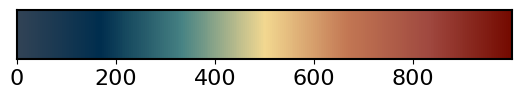

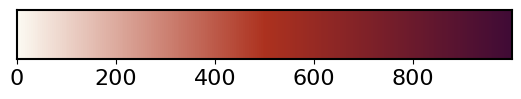

In [119]:
dispmap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])
dispmap([shironeri,palette[2],shikon])


<ipython-input-125-a06a9fb654a8>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


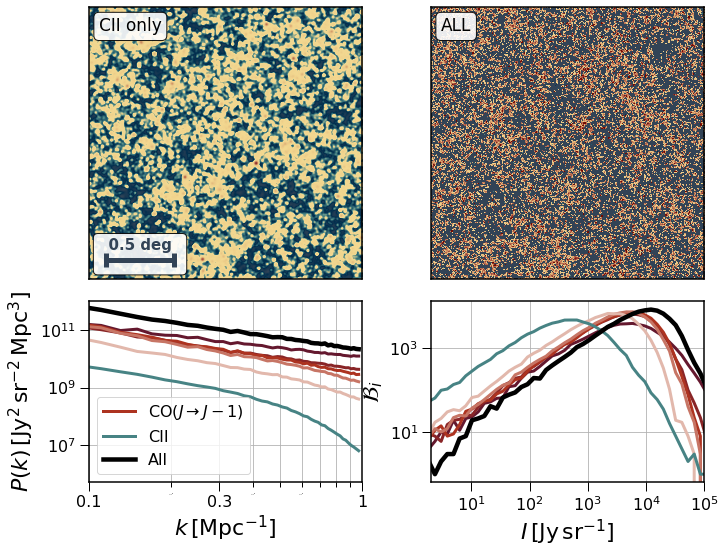

In [125]:
gs_plot = gridspec.GridSpec(2,2,left=0.12,bottom=0.11,right=0.975,top=0.99,
                            wspace=.25,hspace=.1,height_ratios=[3,2])
fig = plt.figure(figsize=(10,7.5))

norm = clrs.TwoSlopeNorm(vcenter=0)

######## MAPS ########

#gs_plot2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_plot[:-1,:],hspace=0.1,wspace=0.25,height_ratios=[8,1])

ax = plt.subplot(gs_plot[0,0])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J43_map.preview(axes=[2,1]),vmax=np.max(np.max(CO_J43_map.preview(axes=[2,1]))))

cb = ax.imshow(cii_proj, extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(15,15,'CII only', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])
rside = x[-1]-x[0]
side = rside/8
cent = 20+side+5
height = y[-1]-y[0]
ax.text(cent,height*0.85,'  0.5 deg  \n', color=aonibi,weight='bold',ha='center',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),va='top')
ax.errorbar(cent,height*0.93,xerr=side,marker='',ls='--',c=aonibi,elinewidth=5,capsize=7,capthick=5,zorder=10)
#rside = x[-1]-x[0]
#cent = rside/5
#side = rside/10
#ax.errorbar(cent,y[-1]-7,xerr=side,marker='',ls='--',c=shironeri,elinewidth=5,capsize=10,capthick=5)
#ax.text(cent,y[-1]-10,r'0.2 deg', color=shironeri,weight='bold',ha='center',va='bottom')

ax = plt.subplot(gs_plot[0,1])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J65_map.preview(axes=[2,1])),vmax=np.max(np.max(CO_J65_map.preview(axes=[2,1]))))
ax.imshow(all_proj, extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(15,15,'ALL', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

######### COLORBAR ##############

#cbar = plt.colorbar(cb,orientation='horizontal',cax=plt.subplot(gs_plot2[1,:]))
#cbar.ax.set_xlabel(r'$\delta I\, \left[{\rm Jy\,sr^{-1}}\right]$', fontsize=24,labelpad = 10)
#cbar.ax.tick_params(labelsize=19,size = 8.) 


######## PK ########

ax = plt.subplot(gs_plot[1,0])
ax.loglog(CO32q['k'], CO32q['Pk'],lw=3,c=cb_CO.to_rgba(3))
ax.loglog(CO43q['k'], CO43q['Pk'],lw=3,c=cb_CO.to_rgba(4))
ax.loglog(CO54q['k'], CO54q['Pk'],lw=3,c=cb_CO.to_rgba(5),label=r'CO($J\rightarrow J-1$)')
ax.loglog(CO65q['k'], CO65q['Pk'],lw=3,c=cb_CO.to_rgba(6))
ax.loglog(CO76q['k'], CO76q['Pk'],lw=3,c=cb_CO.to_rgba(7))
ax.loglog(CIIq['k'], CIIq['Pk'],lw=3,c=seiheki, label=r'CII')
ax.loglog(ALLq['k'], ALLq['Pk'],lw=4.5,color='k',label=r'All')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=0)
ax.legend(loc=3,fontsize=16,ncol=1)
ax.grid(which='both',axis='x')
ax.grid(axis='y')
ax.set_xlim(0.1,1)
ax.set_xticks([0.1,0.3,1])
ax.set_xticklabels(['0.1','0.3','1'])
ax.set_ylim(5e5,1e12)
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$P(k)\,[{\rm Jy^2\,sr^{-2}\,Mpc^{3}}]$',fontsize=22)

######## VID #######

ax = plt.subplot(gs_plot[1,1])
ax.loglog(CO32q['I'], CO32q['VID'],lw=3,c=cb_CO.to_rgba(3))
ax.loglog(CO43q['I'], CO43q['VID'],lw=3,c=cb_CO.to_rgba(4))
ax.loglog(CO54q['I'], CO54q['VID'],lw=3,c=cb_CO.to_rgba(5))
ax.loglog(CO65q['I'], CO65q['VID'],lw=3,c=cb_CO.to_rgba(6))
ax.loglog(CO76q['I'], CO76q['VID'],lw=3,c=cb_CO.to_rgba(7))
ax.loglog(CIIq['I'], CIIq['VID'],lw=3,c=seiheki)
ax.loglog(ALLq['I'], ALLq['VID'],lw=4.5,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$\mathcal{B}_i$',fontsize=22)
ax.set_xlim(2,100000)
#ax.set_ylim(5,2000)
ax.set_xticks([10,100,1000,10000,1e5])

plt.tight_layout()
plt.savefig('../../LC_LIM_interloper_maps.png', dpi=200)
plt.show()

# Diagram plots

In [15]:
LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(nuObs_max = 115.271*u.GHz/3.9,nuObs_min = 115.271*u.GHz/4.1,zmin=2.89,zmax=3.11,
            angular_supersample=15,spectral_supersample=1,beam_FWHM=4*u.arcsec,
            dnu=0.7*u.GHz,do_angular_smooth=False,do_spectral_smooth=False,mass=True,
            RAObs_max=0.5*u.deg,RAObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,DECObs_min=-0.5*u.deg)

In [16]:
point_mass_mass = LC_CO.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.030771505096048424
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_178.fits
The target line requires z_max = 3.100 instead of the nominal 3.100


/home/jlbernal/preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.028660746396658054
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


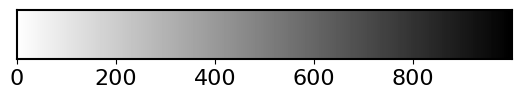

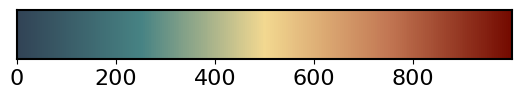

In [54]:
dispmap(['white','black'])
dispmap([grey,seiheki,'#f3d991',orange,shuan])

map_br = makemap([grey,seiheki,'#f3d991',orange,shuan])
greays = makemap(['white','black'])


In [22]:
map_to_plot = point_mass_mass.preview(axes=[1,2])

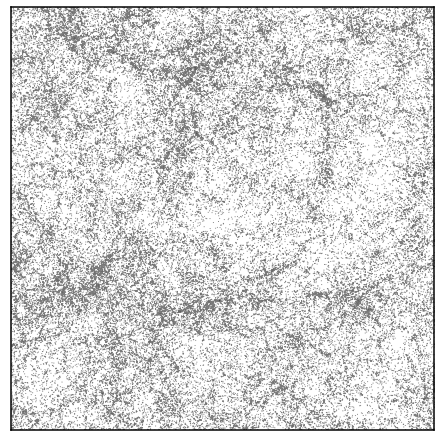

In [40]:
gs_plot = gridspec.GridSpec(1,1,left=0.01,bottom=0.01,right=0.99,top=0.99)
fig = plt.figure(figsize=(6,6))

norm = clrs.TwoSlopeNorm(vcenter=np.max(map_to_plot)/30)

######## MAPS ########

ax = plt.subplot(gs_plot[0,0])

cb = ax.imshow(map_to_plot, cmap=greays,norm=norm,aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../../diag_map1.png')
plt.show()


In [45]:
LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(nuObs_max = 115.271*u.GHz/3.9,nuObs_min = 115.271*u.GHz/4.1,zmin=2.89,zmax=3.11,
            angular_supersample=1,spectral_supersample=1,beam_FWHM=1*u.arcmin,
            dnu=0.7*u.GHz,do_angular_smooth=False,do_spectral_smooth=False,
            RAObs_max=0.5*u.deg,RAObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,DECObs_min=-0.5*u.deg)

In [46]:
binned_map = LC_CO.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.030771505096048424
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_178.fits
The target line requires z_max = 3.100 instead of the nominal 3.100


/home/jlbernal/preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.028660746396658054
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [47]:
map_to_plot = binned_map.preview(axes=[1,2])

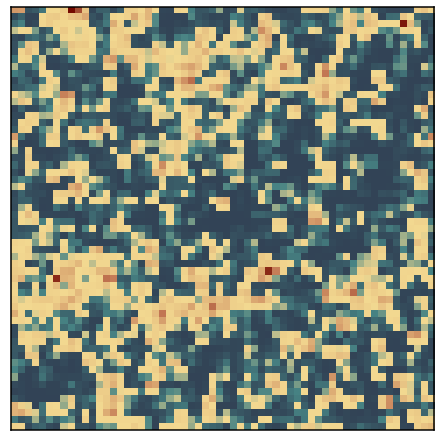

In [55]:
gs_plot = gridspec.GridSpec(1,1,left=0.01,bottom=0.01,right=0.99,top=0.99)
fig = plt.figure(figsize=(6,6))

norm = clrs.TwoSlopeNorm(vcenter=np.min(map_to_plot)/2)

######## MAPS ########

ax = plt.subplot(gs_plot[0,0])

cb = ax.imshow(map_to_plot, cmap=map_br,norm=norm,aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../../diag_map2.png')
plt.show()


In [63]:
LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(nuObs_max = 115.271*u.GHz/3.9,nuObs_min = 115.271*u.GHz/4.1,zmin=2.89,zmax=3.11,
            angular_supersample=10,spectral_supersample=10,beam_FWHM=1*u.arcmin,
            dnu=0.7*u.GHz,do_angular_smooth=True,do_spectral_smooth=True,
            RAObs_max=0.5*u.deg,RAObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,DECObs_min=-0.5*u.deg,do_downsample=False)

In [64]:
smoothed_map = LC_CO.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.030771505096048424
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_174.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_175.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_176.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_177.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_178.fits
The target line requires z_max = 3.100 instead of the nominal 3.100


/home/jlbernal/preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.028660746396658054
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [65]:
map_to_plot = smoothed_map.preview(axes=[1,2])

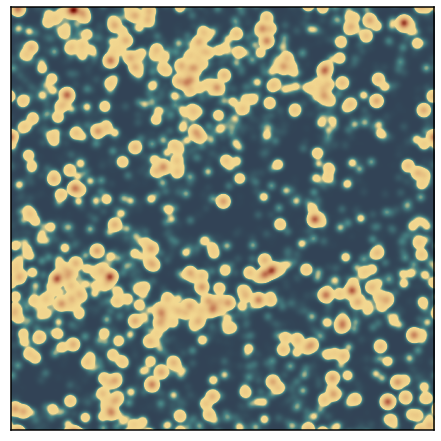

In [67]:
gs_plot = gridspec.GridSpec(1,1,left=0.01,bottom=0.01,right=0.99,top=0.99)
fig = plt.figure(figsize=(6,6))

norm = clrs.TwoSlopeNorm(vcenter=0)

######## MAPS ########

ax = plt.subplot(gs_plot[0,0])

cb = ax.imshow(map_to_plot, cmap=map_br,norm=norm,aspect='auto')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../../diag_map3.png')
plt.show()


In [128]:
zmin_Lya = 4.9
zmax_Lya = 5.1
Lya=make_measurements(dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM',
                          lines=dict(Lyalpha=True),
                           target_line = 'Lyalpha',
                          models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,'psi':0.875,'z0':3.125,'f0':0.18,'SFR0':0.5,'sigma_L':0.3})),
                           do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_Lya-0.03, zmax = zmax_Lya+0.1,
                          RAObs_min=-0.5*u.deg,RAObs_max=0.5*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=-0.5*u.deg,RA_max=0.5*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_Lya/(1+zmin_Lya), nuObs_min=nu_Lya/(1+zmax_Lya),
                          beam_FWHM=6.2*u.arcsec,
                          dnu=17*u.THz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                            angular_supersample=10,
                          spectral_supersample=1,
                          resampler='cic',
                          cube_mode='inner_cube',
                          do_angular_smooth=True,
                          do_spectral_smooth=False,
                           do_z_buffering=True,                          
                           mass=True,
                          seed = 1213,do_intensity=True,do_downsample=False))

AttributeError: 'tuple' object has no attribute 'to'

In [90]:
interlopers['CII_L18']

array([[[-424.44604, -452.18347, -473.7861 , ..., -309.6164 ,
         -353.0809 , -391.31982],
        [-393.135  , -423.56384, -448.95993, ..., -283.08798,
         -322.3089 , -359.09412],
        [-354.7732 , -388.02692, -417.59903, ..., -250.0687 ,
         -284.7887 , -319.89774],
        ...,
        [-475.49567, -496.26562, -508.9129 , ..., -351.4967 ,
         -404.5632 , -445.41455],
        [-465.1305 , -487.894  , -503.0254 , ..., -343.4675 ,
         -393.92917, -434.12698],
        [-448.37903, -473.5233 , -491.68   , ..., -329.69934,
         -376.94153, -416.30225]],

       [[-407.36584, -435.32904, -457.78683, ..., -296.21985,
         -337.82318, -374.7795 ],
        [-369.32385, -400.3131 , -427.27777, ..., -264.12476,
         -300.78992, -335.87903],
        [-323.0418 , -357.23407, -389.15677, ..., -224.48083,
         -255.8623 , -288.81638],
        ...,
        [-469.5697 , -489.87814, -501.72595, ..., -346.7087 ,
         -399.35883, -439.84283],
        [-45

# Trash

In [24]:
LC_CO.do_spectral_smooth*(cu.c*LC_CO.dnu*(1+zmid)/(LC_CO.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC_CO.nuObs_mean)).to(LC_CO.Mpch).value

2.830672142159978

In [25]:
LC_CO.do_angular_smooth*(LC_CO.cosmo.comoving_radial_distance(zmid)*u.Mpc*(LC_CO.beam_width/(1*u.rad))).to(LC_CO.Mpch).value

2.1801838769872433

In [26]:
LC_CII.do_spectral_smooth*(cu.c*LC_CII.dnu*(1+zmid)/(LC_CII.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC_CII.nuObs_mean)).to(LC_CII.Mpch).value

30.216594290256822

In [27]:
LC_CII.do_angular_smooth*(LC_CII.cosmo.comoving_radial_distance(zmid)*u.Mpc*(LC_CII.beam_width/(1*u.rad))).to(LC_CII.Mpch).value

0.3179434820606397

In [20]:
cc

array([[0.12649066, 0.94828428, 0.80625878, 0.78932846],
       [0.93599231, 0.37299162, 0.62416065, 0.30777276],
       [0.78645955, 0.86352441, 0.05267292, 1.02448627],
       [0.35642731, 0.43291183, 0.77238691, 0.25509436]])

In [21]:
cc[cc<0.2] == 1

array([False, False])

In [22]:
cc*2

array([[0.25298132, 1.89656856, 1.61251755, 1.57865692],
       [1.87198462, 0.74598325, 1.2483213 , 0.61554552],
       [1.57291911, 1.72704881, 0.10534584, 2.04897255],
       [0.71285462, 0.86582367, 1.54477382, 0.51018873]])